In [11]:
!pip install opencv-python
!pip install imageio 
!pip install matplotlib

In [13]:
import os
os.sys.path
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import imageio
cv2.ocl.setUseOpenCL(False)
import warnings 
warnings.filterwarnings('ignore')


In [14]:
feature_extraction_algo = 'sift'
feature_to_match = 'bf'

In [15]:
train_photo = cv2.imread('train .jpg')
train_photo = cv2.cvtColor(train_photo, cv2.COLOR_BGR2RGB)
train_photo_gray = cv2.cvtColor(train_photo, cv2.COLOR_RGB2GRAY)

query_photo = cv2.imread('query.jpg')
query_photo = cv2.cvtColor(query_photo, cv2.COLOR_BGR2RGB)
query_photo_gray = cv2.cvtColor(query_photo, cv2.COLOR_RGB2GRAY)

Text(0.5, 0, 'Train Photo (Photo to transform)')

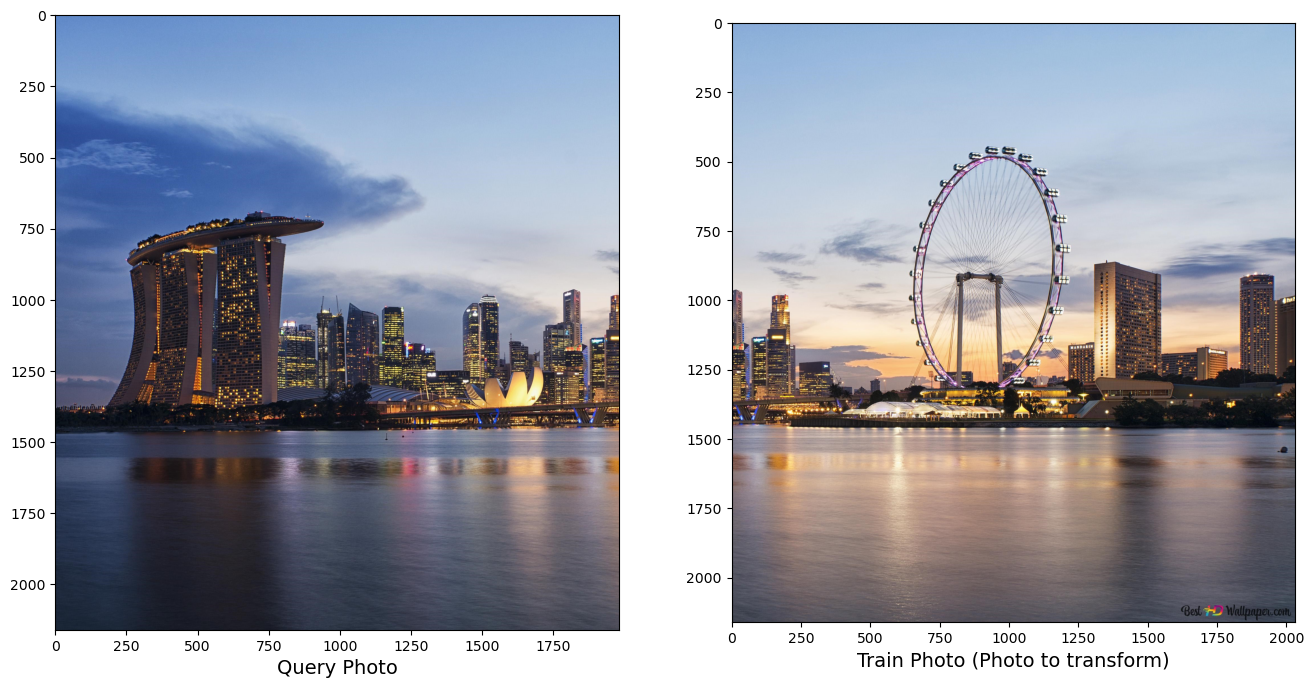

In [16]:
#Viewing the images side by side

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout = False, figsize =(16,9))
ax1.imshow(query_photo, cmap = 'gray')
ax1.set_xlabel('Query Photo', fontsize = 14)

ax2.imshow(train_photo, cmap = 'gray')
ax2.set_xlabel('Train Photo (Photo to transform)', fontsize = 14)


In [17]:
def select_descriptor_method(image, method=None):
    assert method is not None, "Please define a descriptor method. Accepted values are: 'sift', 'surf', 'orb', 'brisk' "
    
    if method =='sift':
        descriptor = cv2.SIFT_create()
    
    if method =='surf':
        descriptor = cv2.SURF_create()
    
    if method =='brisk':
        descriptor = cv2.BRISK_create()
    
    if method =='orb':
        descriptor = cv2.ORB_create()
        
    (keypoints, features) = descriptor.detectAndCompute(image, None)
    
    return(keypoints, features)

In [18]:
keypoints_train_img, feature_train_img = select_descriptor_method(train_photo_gray, method = feature_extraction_algo)
keypoints_query_img, feature_query_img = select_descriptor_method(query_photo_gray, method = feature_extraction_algo)



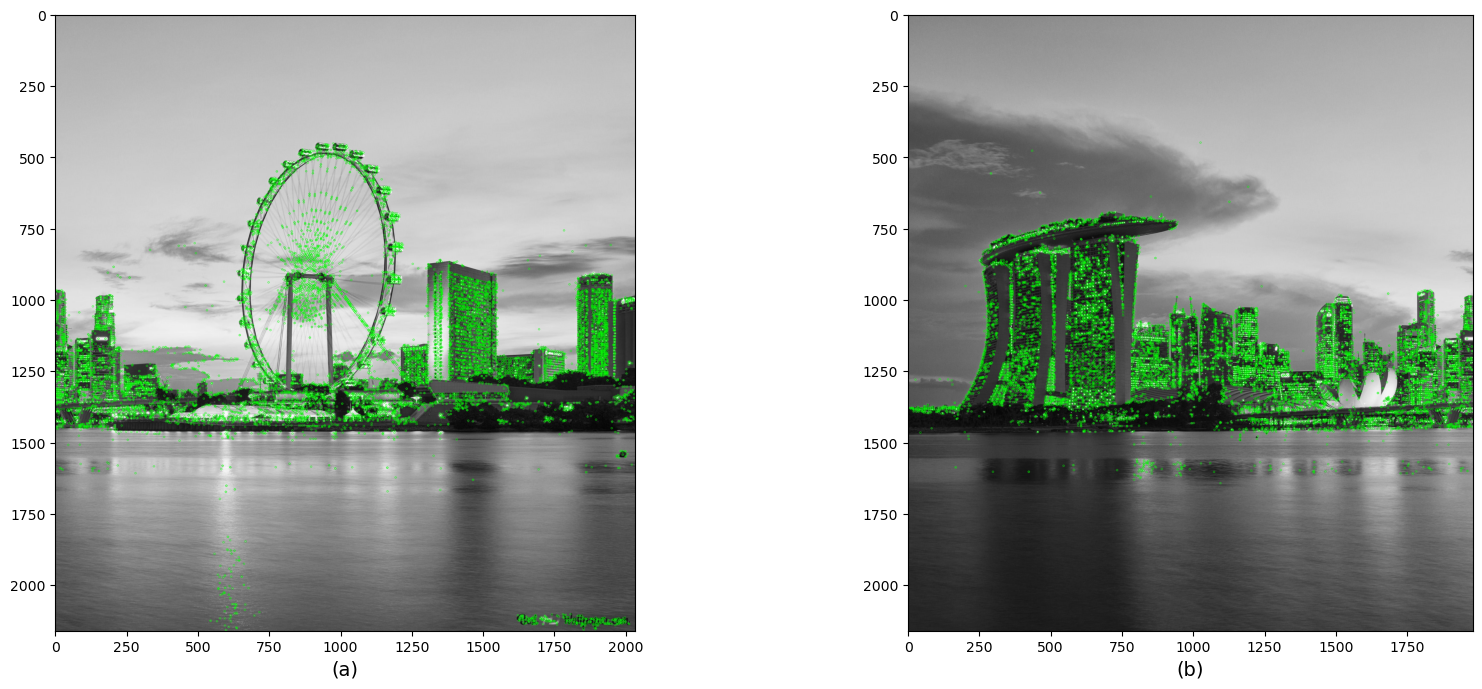

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols =2, figsize=(20,8), constrained_layout =False)

ax1.imshow(cv2.drawKeypoints(train_photo_gray, keypoints_train_img, None, color = (0,255,0)))
ax1.set_xlabel('(a)', fontsize = 14)

ax2.imshow(cv2.drawKeypoints(query_photo_gray, keypoints_query_img, None, color = (0,255,0)))
ax2.set_xlabel('(b)', fontsize = 14)

plt.savefig('./Output' + feature_extraction_algo + '_feature_img' + '.jpeg', bbox_inches ='tight', dpi =300, optimize = True, format = 'jpeg')

plt.show()

In [22]:
def create_matching_object(method, crossCheck):
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck = crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = crossCheck)
    return bf

In [24]:
def key_points_matching(feature_train_img, feature_query_img, method):
    bf = create_matching_object(method, crossCheck=True)
    best_matches = bf.match(feature_train_img, feature_query_img)
    raw_matches = sorted(best_matches, key = lambda x: x.distance)
    print('Raw matches with Brute Force', len(raw_matches))
    
    return raw_matches 

In [25]:
def key_points_matching_KNN(feature_train_img, feature_query_img, ratio, method):
    bf = create_matching_object(method, crossCheck=False)
    
    raw_matches = bf.knnMatch(feature_train_img, feature_query_img, k = 2)
    print('Raw matches with KNN: ', len(raw_matches))
    
    knn_matches = []
    
    for m,n in raw_matches: 
        if m.distance < n.distance * ratio:
            knn_matches.append(m)
            
    return knn_matches             

Drwaing matched features for:  bf
Raw matches with Brute Force 3367


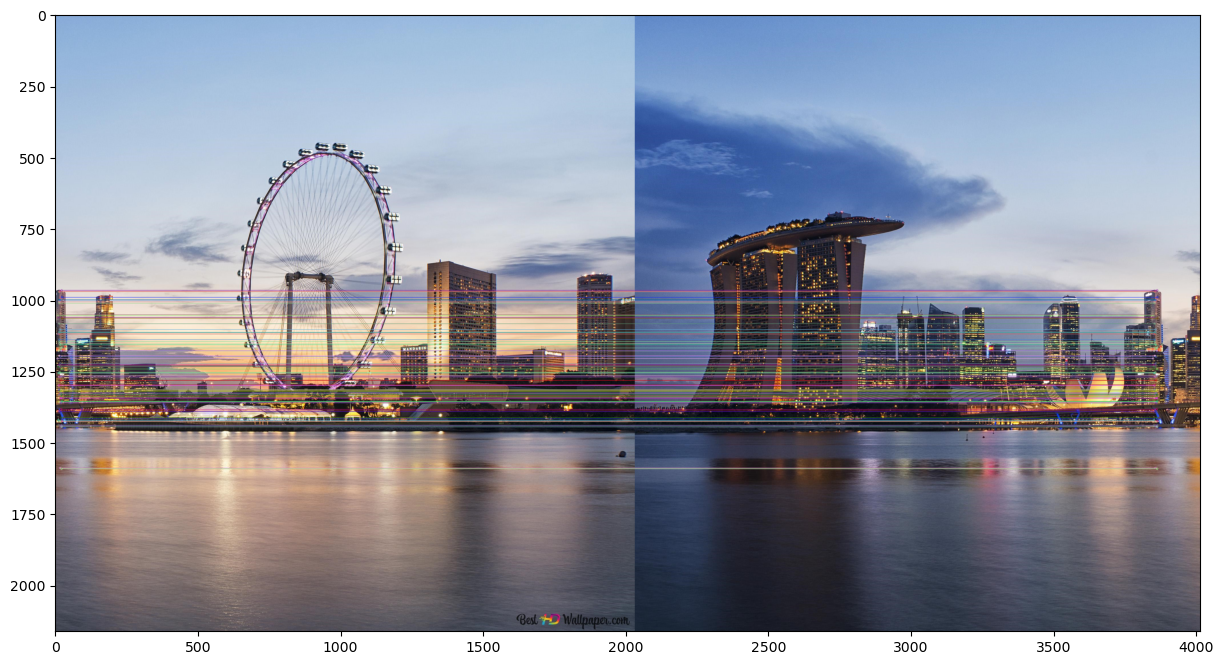

In [31]:
print('Drwaing matched features for: ', feature_to_match)

fig = plt.figure(figsize = (20,8))

if feature_to_match == 'bf':
    matches = key_points_matching(feature_train_img, feature_query_img, method = feature_extraction_algo)
    
    mapped_feature_image = cv2.drawMatches(train_photo, keypoints_train_img, query_photo, keypoints_query_img, matches[:100], None, flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
elif feature_to_match == 'knn':
        matches = key_points_matching_KNN(feature_train_img, feature_query_img, method = feature_extraction_algo)
        
        mapped_feature_image_knn = cv2.drawMatches(train_photo, keypoints_train_img, query_photo, keypoints_query_img, np.random.choice(matches,100), None, flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        
plt.imshow(mapped_feature_image)    

In [40]:
def homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh):
    #Convert to Numpy array 
    
    keypoints_train_img = np.float32([keypoint.pt for keypoint in keypoints_train_img])
    keypoints_query_img = np.float32([keypoint.pt for keypoint in keypoints_query_img])
    
    if len(matches) > 4:
        points_train = np.float32([keypoints_train_img[m.queryIdx] for m in matches])
        points_query = np.float32([keypoints_query_img[m.trainIdx] for m in matches])
        
        (H, status) = cv2.findHomography(points_train, points_query, cv2.RANSAC, reprojThresh)
        
        return(matches, H, status)
    else: 
        return None

In [43]:
M = homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh = 4)

if M is None:
    print('Error')
    
(matches, Homography_Matrix, status) = M
    
print(Homography_Matrix)
    

[[ 1.00009140e+00  1.01857449e-05  1.80799834e+03]
 [ 5.86441004e-05  1.00001633e+00 -1.28748095e-02]
 [ 4.47963828e-08  4.83967343e-09  1.00000000e+00]]


In [44]:
width = query_photo.shape[1] + train_photo.shape[1]
print(width)

height = max(query_photo.shape[0], train_photo.shape[0])
print(height)

4013
2160


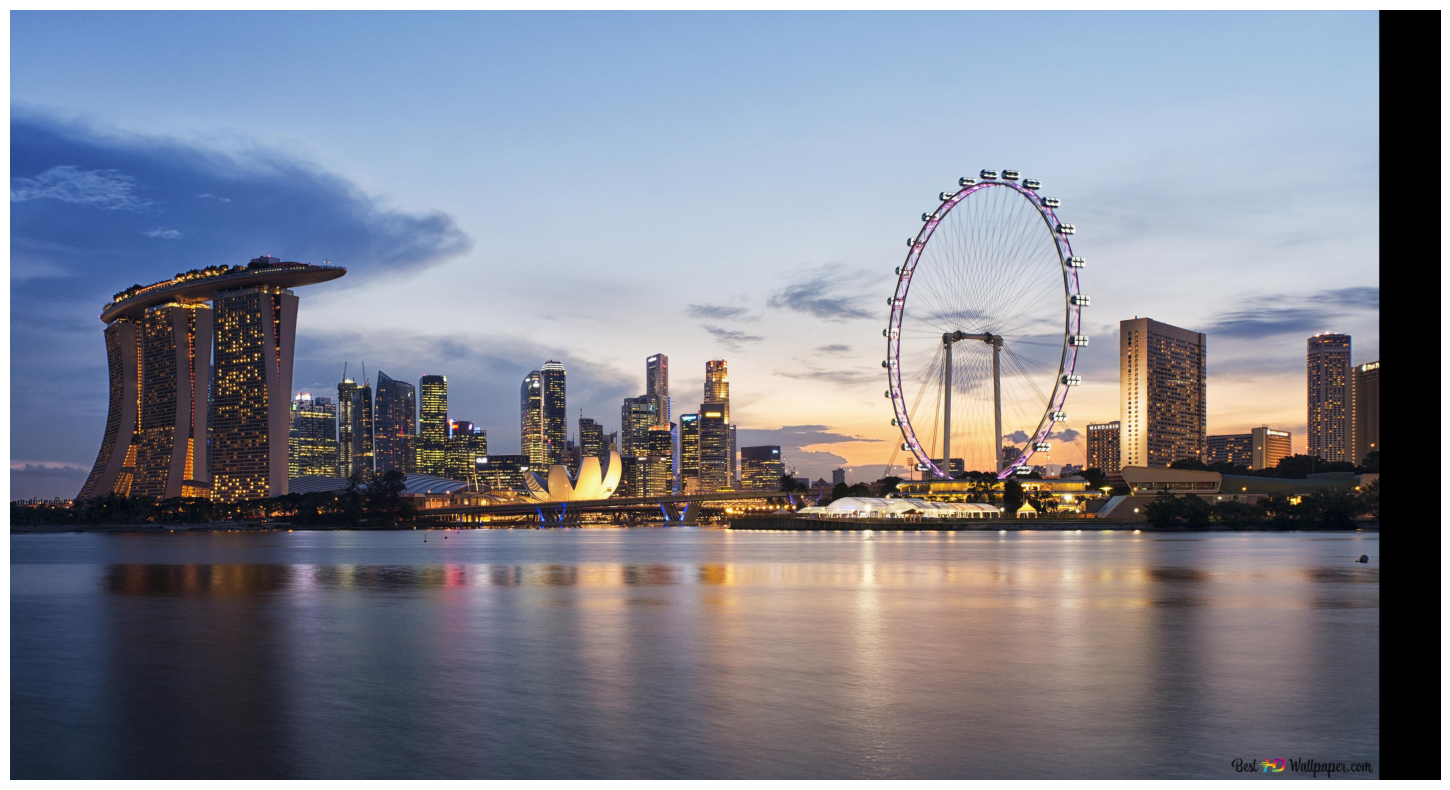

In [46]:
result = cv2.warpPerspective(train_photo, Homography_Matrix, (width,height))

result[0:query_photo.shape[0], 0:query_photo.shape[1]] = query_photo

plt.figure(figsize = (20,10))
plt.axis('off')
plt.imshow(result)
